# shale oil conductance calculation and permeability

Ke Wang presented a method for shale oil conductance calculation[^1]. I also used it to do some work. Now I wanna show how to implement this method by OpenPNM. Both of us use OpenPNM and I get a permission from Ke Wang to add this method in OpenPNM release, if possible. Before I add it as a physics model in `hydraulic_conductance.py`, I think it is better to write just a function and get tested by other users and developers.

## how to calculate shale oil conductance

I think it is worthy to introduce the method they use to calculate shale oil conductance briefly first, before I show the code.

Afsharpoor presented an equation to calculate liquid slip flow in a network of shale noncircular nanopores[^2].

$$
Q=\frac{A^{2}}{\mu L}\left(a+b L_{\mathrm{sd}}+c G+d L_{\mathrm{sd}}^{2}+e G^{2}+f L_{\mathrm{sd}} G\right) \Delta P
$$

Wang consider the adsorption effect and introduce adsorption layer and adsorption layer viscosity:

$$
A_a = A - A_b \\
\mu_r = \frac{\mu(A - A_a) + \mu \alpha A_a}{A} \\
\alpha = \frac{\mu_a}{\mu}
$$

Finally the equation is in the form of

$$
Q=\frac{A^{3}}{\left(A-A_{\mathrm{a}}+\alpha A_{\mathrm{a}}\right) \times \mu L}\left(a+b L_{\mathrm{sd}}+c G+d L_{\mathrm{sd}}^{2}+e G^{2}+f L_{\mathrm{sd}} G\right) \Delta P
$$

Please find the symbols' physical meaning in the references.


[^1]:Yang Y., Wang K., Zhang L., et al. Pore-scale simulation of shale oil flow based on pore network model. Fuel, 2019, 251: 683-692.
[^2]: Afsharpoor A., Javadpour F. Liquid slip flow in a network of shale noncircular nanopores. Fuel, 2016, 180: 580-590.

In [1]:
import openpnm as op
import random
import numpy as np
from bimodal_distribution import bimodal_distribution
import matplotlib.pyplot as plt
import openpnm.models as mods

IndexError: tuple index out of range

In [2]:
ws = op.Workspace()
ws.clear()

pore number, throat number, network size are designed from Wang's paper (ref[1]), to make sure that pore and throat volume density is the same. 

In [3]:
np.random.seed(0)
pn = op.network.Delaunay(points=1415, shape=[4.036e-6, 4.036e-6, 4.036e-6])
pn.project.name = 'shale'

In [7]:
ts = random.sample(list(pn.Ts), 3158)
trim_ts = np.setdiff1d(pn.Ts, ts)
op.topotools.trim(pn, pores=[], throats=trim_ts)

check data health is veeeeeeery important. I forgot this step and got stucked for more than a month.

In [8]:
# check data health and trim
health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health["trim_pores"])

In [9]:
# pnm geometry
geo = op.geometry.GenericGeometry(network=pn, pores=pn.pores(), throats=pn.throats())

Pore size is set in the range of 25-250 $\mu$m, to produce the same PSD in fig 2(a). It is packed as a function `bimodal_distribution`.

In [10]:
# add properties to geo
geo['pore.diameter'] = bimodal_distribution(pn.Np)

In [11]:
geo.add_model(propname='throat.max_size',
              model=mods.misc.from_neighbor_pores,
              mode='min',
              prop='pore.diameter')

In [12]:
geo.add_model(propname='throat.diameter',
              model=mods.misc.scaled,
              factor=0.5,
              prop='throat.max_size')
geo['throat.radius'] = geo['throat.diameter'] / 2

In [13]:
geo.add_model(propname='pore.cross_sectional_area',
              model=mods.geometry.pore_cross_sectional_area.sphere,
              pore_diameter='pore.diameter')

In [14]:
geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)

In [15]:
geo.add_model(propname='throat.length',
              model=mods.geometry.throat_length.spheres_and_cylinders,
              pore_diameter='pore.diameter',
              throat_diameter='throat.diameter')

In [16]:
geo.add_model(propname='throat.cross_sectional_area',
              model=mods.geometry.throat_cross_sectional_area.cylinder,
              throat_diameter='throat.diameter')

In [17]:
geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder,
              throat_diameter='throat.diameter',
              throat_length='throat.length')

In [18]:
geo.add_model(propname='throat.cross_sectional_area',
             model=mods.geometry.throat_cross_sectional_area.cylinder,
             throat_diameter='throat.diameter')

In [19]:
geo.add_model(propname='throat.conduit_lengths',
              model=mods.geometry.conduit_lengths.spheres_and_cylinders,
              pore_diameter='pore.diameter',
              throat_diameter='throat.diameter')

In [20]:
geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)

# shape factor
geo.add_model(propname='throat.perimeter',
              model=mods.geometry.throat_perimeter.cylinder,
              throat_diameter='throat.diameter')

geo.add_model(propname='throat.shape_factor',
              model=mods.geometry.throat_capillary_shape_factor.mason_morrow,
              throat_perimeter='throat.perimeter',
              throat_area='throat.cross_sectional_area')

geo['pore.perimeter'] = np.pi * geo['pore.diameter']
geo['pore.shape_factor'] = geo['pore.cross_sectional_area'] / geo['pore.perimeter'] ** 2

# organic pores
geo['pore.organic'] = geo['pore.diameter'] <= 50e-9

organic_pores = [pore_index for pore_index in geo.pores()
                if geo['pore.organic'][pore_index]==True]
organic_pores = np.array(organic_pores)

# organic throats
from find_organic_throats import find_organic_throats
organic_throats = find_organic_throats(organic_pores,
                                       geo['throat.conns'], geo.Nt)
organic_thro = np.array(organic_throats[0])
organic_thro_indx = np.array(organic_throats[1])

geo['throat.organic'] = geo.tomask(throats=organic_thro_indx)

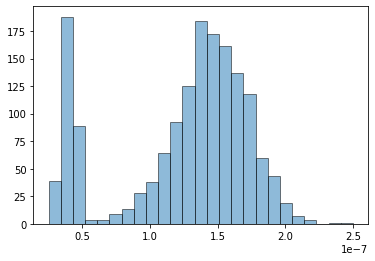

In [21]:
fig = plt.hist(geo['pore.diameter'], bins=25, 
               density=False, edgecolor='k', alpha=0.5)
#plt.savefig('shale-diameter.png')

According to ref [^1], organic pores are mostly less than 50 nm in diameters. So, 50 nm is considered as the boundary between organic and inorganic pores. Organic throats are those connected to both organic pores in two ends. I write a function `find_organic_throats` to finish the job.

Viscosity ratio ($\alpha$) in organic pores is set as 1.1.
Viscosity ratio ($\alpha$) in inorganic proes is set as 0.9.

In [22]:
# physics
water = op.phases.Water(network=geo)

# viscosity settings
alpha_o = 1.1  # viscosity ratio in organic pores = \mu_a / \mu, range(1-2.5)
alpha_i = 0.9  # viscosity ratio in inorganic pores, range(0.5-1)

# initialize
water['pore.viscosity'] = 3.6e-3
water['throat.viscosity'] = 3.6e-3
water['pore.viscosity_a'] = water['pore.viscosity'] * alpha_i
water['throat.viscosity_a'] = water['throat.viscosity'] * alpha_i

Slip length and viscosity are different in organic and inorganic pores.

In [23]:
# slip length
Ls_o = 60e-9 # organic slip length, range 0-250 nm
Ls_i = 50e-9 # organic slip length, range 0-60 nm

# slip length of inorganic pores and throats
water['pore.l_sd'] = Ls_i /  np.sqrt(geo['pore.cross_sectional_area'])
water['throat.l_sd'] = Ls_i /  np.sqrt(geo['throat.cross_sectional_area'])


if organic_pores.size!=0:
    # dimensionless slip length of organic pores and throats
    water['pore.l_sd'][organic_pores] =\
                    Ls_o / np.sqrt(geo['pore.cross_sectional_area'][organic_pores])
    #excute when organic pores exist.
    water['pore.viscosity_a'][organic_pores] =\
                    water['pore.viscosity'][organic_pores] * alpha_o

if organic_thro.size!=0:
    water['throat.l_sd'][organic_thro_indx] =\
                    Ls_o /  np.sqrt(geo['throat.cross_sectional_area'][organic_thro_indx])
    water['throat.viscosity_a'][organic_thro_indx] =\
                    water['throat.viscosity'][organic_thro_indx] * alpha_o

In [24]:
ha = 1.8e-9 # adsorption layer thickness
geo['pore.cross_sectional_area_a'] = geo['pore.cross_sectional_area'] - \
                     np.pi * (geo['pore.diameter'] / 2 - ha) ** 2
geo['throat.cross_sectional_area_a'] = geo['throat.cross_sectional_area'] - \
                       np.pi * (geo['throat.radius'] - ha) ** 2

The `if else` statement below is used to compare the difference between shale oil conductance and classical hydraulic conductance assumption.

In [25]:
slip = True
# hydraulic conductance
if slip==True:
    # hydraulic conductance
    from conductance_calculas import slip_shale_conductance
    water['throat.hydraulic_conductance'] = slip_shale_conductance(water)
else:
    water.add_model(propname='throat.hydraulic_conductance',
                    model=op.models.physics.hydraulic_conductance.hagen_poiseuille)

In [27]:
# permeability
flow = op.algorithms.StokesFlow(network=pn, phase=water)
flow.set_value_BC(pores=pn['pore.left'], values=20)  # inlet
flow.set_value_BC(pores=pn['pore.right'], values=10)  # outlet
flow.run()

Q1 = flow.rate(pores=geo['pore.left'])
Q2 = flow.rate(pores=geo['pore.right'])

side_len = 4.036e-6

domain_area = side_len **2
domain_length = side_len

K2 = flow.calc_effective_permeability(inlets=geo['pore.left'], outlets=geo['pore.right'],
                                    domain_area=domain_area, domain_length=domain_length)
K1 = flow.calc_effective_permeability()
print(K2)
print(K1)

------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2021-11-05 15:41:00,475
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2021-11-05 15:41:01,352
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2021-11-05 15:41:01,352
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2021-11-05 15:41:01,355
---------------------------------------

[7.3612224e-18]
[9.12824796e-18]


In [ ]:
# op.io.VTK.export_data(network=pn, phases=[flow], filename=r'shale_test')

Because `Delaunay` construct random networks and random pore size, each time the final result may be different. I only show one of the result in my PC.

**Pressure distribution**
![pressure distribution](single-phase-pressure.png)

**organic distribution**
![organic distribution](organic-distribution.png)

Red color shows organic pores and throats.